## Step 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import re
import emoji

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from wordcloud import WordCloud

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Step 2. Load Data

In [3]:
df = pd.read_csv('../Data/reddit_posts_VisitingHawaii.csv') 

In [4]:
df.head(3)

,created_utc,title,self_text,subreddit
0,1.709520e+09,Hanauma Bay Tour Guides,Hi all. I know this topic has been discussed ad nauseam but Reddit search results and Google aren't really clear. I'm visiting Oahu in mid-June and would like to visit Hanauma Bay with my wife. I am aware reservations are needed and they go fast. We'll have a car and could drive there early in our car but I've heard that can be a hassle. My question is: Do you know of any tour companies that a...,VisitingHawaii
1,1.709519e+09,Good + easily walkable food near Hilton Village?,"Have a 8 night stay at the Hilton Village with our young kids, but we are bringing our parents so looking for good food options that are not a super long walk. Throw other options out there that aren’t close because we do have a driver who can take us places , but would prefer some close options for lazy days. Budget is not a question if it’s good!",VisitingHawaii
2,1.709530e+09,Selling 4 discounted tickets to Kualoa Ranch Jurassic Valley Zipline!!,"My friends and I went a couple months ago and were late to our tour 😭 we couldnt get refunded and they only offered gift credit basically for a visit for next time. We'd prefer not to have to travel to Oahu again just to redeem this so we're hoping we can offer someone else a better price. I believe its usually around 185 each, we'll do 160 each!!\n\n",VisitingHawaii


In [5]:
df.subreddit.unique()

array(['VisitingHawaii'], dtype=object)

In [6]:
df.shape

(2380, 4)

In [7]:
df_t = pd.read_csv('../Data/reddit_posts_Europetravel.csv')

In [8]:
df_t.shape

(2020, 4)

## Step 3. Data Cleaning

In [9]:
df.isnull().sum()

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [10]:
df_t.isnull().sum()

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

### Remove **'\n'**

In [11]:
df['cleaned_title'] = df['title'].apply(lambda x: x.replace('\n',' '))
df['cleaned_selftext'] = df['self_text'].apply(lambda x: x.replace('\n',' '))

In [12]:
df_t['cleaned_title'] = df_t['title'].apply(lambda x: x.replace('\n',' '))
df_t['cleaned_selftext'] = df_t['self_text'].apply(lambda x: x.replace('\n',' '))

In [13]:
df['created_datetime'] = df['created_utc'].apply(lambda x: pd.to_datetime(x, unit='s'))
df['date'] = df['created_datetime'].dt.date
df['time'] = df['created_datetime'].dt.time

df['year'] = df['created_datetime'].dt.year
df['month'] = df['created_datetime'].dt.month

In [14]:
df.sample(5)

,created_utc,title,self_text,subreddit,cleaned_title,cleaned_selftext,created_datetime,date,time,year,month
388,1.706467e+09,Day trip to Kauai advice?,"Hello!\n\nMy husband and I are honeymooning in Maui for 10 days, Feb 28-March 9. We really dreamed of going to Kauai but we were given a very generous offer of using a family members time share on Maui that we couldn’t pass up and we are so thrilled! However, we would love to visit Kauai for one day while we are there and found it’s super inexpensive to do so flying Hawaiian airlines. What are...",VisitingHawaii,Day trip to Kauai advice?,"Hello! My husband and I are honeymooning in Maui for 10 days, Feb 28-March 9. We really dreamed of going to Kauai but we were given a very generous offer of using a family members time share on Maui that we couldn’t pass up and we are so thrilled! However, we would love to visit Kauai for one day while we are there and found it’s super inexpensive to do so flying Hawaiian airlines. What are t...",2024-01-28 18:34:26,2024-01-28,18:34:26,2024,1
2007,1.677021e+09,Is staying in/near HVNP worth it for one night?,"Debating whether to stay in/near Hawaii Volcano National Park for one night.\n\nWill be in northern part of big island for majority of my stay, and since it’s about 2+ hr drive I’m wondering if ppl recommend staying closer to HVNP since I plan on flying out of Kona the next day so would like to avoid driving back and forth.\n\nAnyone have places they’d recommend? If in HVNP any place with a co...",VisitingHawaii,Is staying in/near HVNP worth it for one night?,"Debating whether to stay in/near Hawaii Volcano National Park for one night. Will be in northern part of big island for majority of my stay, and since it’s about 2+ hr drive I’m wondering if ppl recommend staying closer to HVNP since I plan on flying out of Kona the next day so would like to avoid driving back and forth. Anyone have places they’d recommend? If in HVNP any place with a cool v...",2023-02-21 23:04:40,2023-02-21,23:04:40,2023,2
987,1.692038e+09,Visiting Hawaii,"From a non-native/non-local (myself), can someone (local/native/other) help me understand the debate of local/natives not wanting tourists to come to any of the islands vs those who say it is ok? I am hoping this conversation can be as respectful as possible but I know it is hard during such an unimaginable time.\n\nThere is an abundance of information being spread on all social media platfor...",VisitingHawaii,Visiting Hawaii,"From a non-native/non-local (myself), can someone (local/native/other) help me understand the debate of local/natives not wanting tourists to come to any of the islands vs those who say it is ok? I am hoping this conversation can be as respectful as possible but I know it is hard during such an unimaginable time. There is an abundance of information being spread on all social media platforms...",2023-08-14 18:32:28,2023-08-14,18:32:28,2023,8
1142,1.682982e+09,Looking for community input on new sidebar widget.,&#x200B;\n\nhttps://preview.redd.it/u4yfmg2jwaxa1.png?width=604&format=png&auto=webp&s=fcaf86c69b859b830426445098f14c578b990766,VisitingHawaii,Looking for community input on new sidebar widget.,&#x200B; https://preview.redd.it/u4yfmg2jwaxa1.png?width=604&format=png&auto=webp&s=fcaf86c69b859b830426445098f14c578b990766,2023-05-01 23:03:15,2023-05-01,23:03:15,2023,5
77,1.708900e+09,Kauai + either Maui or Oahu,"I'll be vising Kauai near the end of March, for 11 days. I have not booked our return flight yet (but I did book my flight to Kauai).\n\nOn our return journey, we have to fly from Kauia via either Maui or Oahu. We are thinking of spending 1 or 2 nights in Maui or Oahu. Which island is better for a short 1-2 night visit? \n\nThanks!\n\n&#x200B;",VisitingHawaii,Kauai + either Maui or Oahu,"I'll be vising Kauai near the end of March, for 11 days. I have not booked our return flight yet (but I did book my flight to Kauai). On our return journey, we have to fly from Kauia via either Mau

In [15]:
df_t['created_datetime'] = df_t['created_utc'].apply(lambda x: pd.to_datetime(x, unit='s'))
df_t['date'] = df_t['created_datetime'].dt.date
df_t['time'] = df_t['created_datetime'].dt.time

df_t['year'] = df_t['created_datetime'].dt.year
df_t['month'] = df_t['created_datetime'].dt.month

###   Posts contain URLs

In [16]:
titel_with_urls = list(df.loc[df['cleaned_title'].str.contains('http'), 'title'])
print('Number of title with URLs within: {}'.format(len(titel_with_urls)))
post_with_urls = list(df.loc[df['cleaned_selftext'].str.contains('http'), 'self_text'])
print('Number of selftext with URLs within: {}'.format(len(post_with_urls)))

Number of title with URLs within: 0
Number of selftext with URLs within: 116


In [17]:
print(post_with_urls[24])

 [California man swept out to sea in Hawaii | KTLA](https://ktla.com/news/california/reports-search-for-california-man-swept-out-to-sea-in-hawaii-called-off/) 


### Clean URLs

In [18]:
titel_with_urls = list(df_t.loc[df_t['cleaned_title'].str.contains('http'), 'title'])
print('Number of title with URLs within: {}'.format(len(titel_with_urls)))
post_with_urls = list(df_t.loc[df_t['cleaned_selftext'].str.contains('http'), 'self_text'])
print('Number of selftext with URLs within: {}'.format(len(post_with_urls)))

Number of title with URLs within: 0
Number of selftext with URLs within: 88


In [19]:
post_with_urls[2]

'Highly interested in these 4 areas.\n\nWill these 4 areas feel different in terms culture, food, lifestyle, price, or will they be quite similar in any sense?\n\nWould love to hear your comments and learn more about this region!\n\nhttps://preview.redd.it/d1f6fcn7ohlc1.jpg?width=1104&format=pjpg&auto=webp&s=f4263e54736fedfdb3c97c3a20ea1721b0cadbc4\n\n&#x200B;'

### Clean HTML encoded characters

In [20]:
warnings.filterwarnings('ignore', category=MarkupResemblesLocatorWarning)

In [21]:
def clean_html_encodings(raw_string):
    return BeautifulSoup(unescape(raw_string), 'lxml').text
    


In [22]:
df['cleaned_title'] = df['cleaned_title'].apply(clean_html_encodings)
df['cleaned_selftext'] = df['cleaned_selftext'].apply(clean_html_encodings)

df_t['cleaned_title'] = df_t['cleaned_title'].apply(clean_html_encodings)
df_t['cleaned_selftext'] = df_t['cleaned_selftext'].apply(clean_html_encodings)

In [23]:
link_pattern = r'\(?https?://[a-zA-Z0-9_$@:%=~#\?\&\+;\-]+([\.\/][a-zA-Z0-9_@:%=~#\?\&\+;\-]+)*\)?'
df.loc[:,'cleaned_selftext'] = df.loc[:,'cleaned_selftext'].apply(lambda s: re.sub(link_pattern, ' ', s))
df_t.loc[:,'cleaned_selftext'] = df_t.loc[:,'cleaned_selftext'].apply(lambda s: re.sub(link_pattern, ' ', s))

### Checking title with emojis

In [24]:
df['title_emoji_count'] = df['cleaned_title'].apply(lambda text: emoji.emoji_count(text))
emoji_title = list(df.loc[df.loc[:,'title_emoji_count']>0,'cleaned_title'])
print('Number of title with emojis within: {}'.format(len(emoji_title)))

df_t['title_emoji_count'] = df_t['cleaned_title'].apply(lambda text: emoji.emoji_count(text))
emoji_title = list(df_t.loc[df_t.loc[:,'title_emoji_count']>0,'cleaned_title'])
print('Number of title with emojis within: {}'.format(len(emoji_title)))

Number of title with emojis within: 21
Number of title with emojis within: 7


In [25]:
emoji_title[3]

'🔥looking for special, interesting places in Europe🔥'

### Checking self text with emojis

In [26]:
df['selftext_emoji_count'] = df['cleaned_selftext'].apply(lambda text: emoji.emoji_count(text))
emoji_text = list(df.loc[df.loc[:,'selftext_emoji_count']>0,'cleaned_selftext'])
print('Number of self text with emojis within: {}'.format(len(emoji_text)))

df_t['selftext_emoji_count'] = df_t['cleaned_selftext'].apply(lambda text: emoji.emoji_count(text))
emoji_text = list(df_t.loc[df_t.loc[:,'selftext_emoji_count']>0,'cleaned_selftext'])
print('Number of self text with emojis within: {}'.format(len(emoji_text)))

Number of self text with emojis within: 126
Number of self text with emojis within: 82


### Emojis cleaning

In [27]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

In [28]:
# Replace emojis with an empty string
df['cleaned_title'] = df['cleaned_title'].apply(lambda s: emoji_pattern.sub(r'', s))
df['cleaned_selftext'] = df['cleaned_selftext'].apply(lambda s: emoji_pattern.sub(r'', s))

df_t['cleaned_title'] = df_t['cleaned_title'].apply(lambda s: emoji_pattern.sub(r'', s))
df_t['cleaned_selftext'] = df_t['cleaned_selftext'].apply(lambda s: emoji_pattern.sub(r'', s))

## Step 4. EDA

In [29]:
# Adding full text column to combine text between cleaned title and selftext
df['full_text'] = df['cleaned_title'] + ' ' + df['cleaned_selftext']

df_t['full_text'] = df_t['cleaned_title'] + ' ' + df_t['cleaned_selftext']

In [30]:
# Counting cleaned title words
df['title_words_count'] = df.cleaned_title.apply(lambda x: len(x.split()))

df_t['title_words_count'] = df_t.cleaned_title.apply(lambda x: len(x.split()))

In [31]:
# Counting cleaned self text words
df['selftext_words_count'] = df.cleaned_selftext.apply(lambda x: len(x.split()))

df_t['selftext_words_count'] = df_t.cleaned_selftext.apply(lambda x: len(x.split()))

In [32]:
# Counting cleaned full text words
df['full_text_count'] = df.full_text.apply(lambda x: len(x.split()))

df_t['full_text_count'] = df_t.full_text.apply(lambda x: len(x.split()))

In [33]:
df.sample(5)

,created_utc,title,self_text,subreddit,cleaned_title,cleaned_selftext,created_datetime,date,time,year,month,title_emoji_count,selftext_emoji_count,full_text,title_words_count,selftext_words_count,full_text_count
733,1.703793e+09,Kalua pork and poi or kalbi on the way or in Haleiwa?,"We will be flying in hungry at 10:30 AM. We will have a car. We want to eat kalua pork with poi then poke and garlic skrimps in Haleiwa. Where should we go? Eventually will make our way to Kalbi on fire, Waiahole, Da Ono, Helena’s, Kahiau, Kyung’s, Pipeline and more. Thank you.",VisitingHawaii,Kalua pork and poi or kalbi on the way or in Haleiwa?,"We will be flying in hungry at 10:30 AM. We will have a car. We want to eat kalua pork with poi then poke and garlic skrimps in Haleiwa. Where should we go? Eventually will make our way to Kalbi on fire, Waiahole, Da Ono, Helena’s, Kahiau, Kyung’s, Pipeline and more. Thank you.",2023-12-28 19:53:11,2023-12-28,19:53:11,2023,12,0,0,"Kalua pork and poi or kalbi on the way or in Haleiwa? We will be flying in hungry at 10:30 AM. We will have a car. We want to eat kalua pork with poi then poke and garlic skrimps in Haleiwa. Where should we go? Eventually will make our way to Kalbi on fire, Waiahole, Da Ono, Helena’s, Kahiau, Kyung’s, Pipeline and more. Thank you.",12,53,65
119,1.708539e+09,Not much adventuring in Kona?,"Hi,\n\nI'm planning a 6-day family vacation on the Big Island (mom with 2 teenage boys). I'm really intrigued by the King Kamehameha Hotel and would like to stay there, but it looks like there's not much to do in Kona. I'm thinking I will split my trip and spend part of it there in Kona, and the other part in Hilo or Volcano. I was originally thinking I'd split it directly in half, but I'm ...",VisitingHawaii,Not much adventuring in Kona?,"Hi, I'm planning a 6-day family vacation on the Big Island (mom with 2 teenage boys). I'm really intrigued by the King Kamehameha Hotel and would like to stay there, but it looks like there's not much to do in Kona. I'm thinking I will split my trip and spend part of it there in Kona, and the other part in Hilo or Volcano. I was originally thinking I'd split it directly in half, but I'm st...",2024-02-21 18:13:32,2024-02-21,18:13:32,2024,2,0,0,"Not much adventuring in Kona? Hi, I'm planning a 6-day family vacation on the Big Island (mom with 2 teenage boys). I'm really intrigued by the King Kamehameha Hotel and would like to stay there, but it looks like there's not much to do in Kona. I'm thinking I will split my trip and spend part of it there in Kona, and the other part in Hilo or Volcano. I was originally thinking I'd split i...",5,266,271
1315,1.686751e+09,ASL/deaf friendly surf instructors at O'ahu?,"Curious if anyone's got any knowledge about any surf instructors at O'ahu who know ASL/sign language. Even just a handful of signs and some patience would be tremendously helpful, so I wouldn't have to be totally reliant on lipreading! Thanks in advance! \n\nDetails - mid November; 1 week in Kaua'i, then 1 week on O'ahu, probably staying in the Waikiki area as the hotels there are reasonably ...",VisitingHawaii,ASL/deaf friendly surf instructors at O'ahu?,"Curious if anyone's got any knowledge about any surf instructors at O'ahu who know ASL/sign language. Even just a handful of signs and some patience would be tremendously helpful, so I wouldn't have to be totally reliant on lipreading! Thanks in advance! Details - mid November; 1 week in Kaua'i, then 1 week on O'ahu, probably staying in the Waikiki area as the hotels there are reasonably pr...",2023-06-14 14:03:31,2023-06-14,14:03:31,2023,6,0,0,"ASL/deaf friendly surf instructors at O'ahu? Curious if anyone's got any knowledge about any surf instructors at O'ahu who know ASL/sign language. Even just a handful of signs and some patience would be tremendously helpful, so I wouldn't have to be totally reliant on lipreading! Thanks in advance! Details - mid November; 1 week in Kaua'i, then 1 week on O'ahu, pro

In [34]:
df_t.sample(5)

,created_utc,title,self_text,subreddit,cleaned_title,cleaned_selftext,created_datetime,date,time,year,month,title_emoji_count,selftext_emoji_count,full_text,title_words_count,selftext_words_count,full_text_count
383,1.707993e+09,What countries to visit in Europe next?,"I’ve been to Spain (Barcelona, Madrid, Sevilla, San Sebastian, Toledo, Granada, Cordoba Malaga, Portugal - Lisbon and Porto, Slovenia Ljubljana, Hungary Budapest, Czech Republic Prague, Austria Vienna, and Italy - Rome, Florence and Venice…\n\nWhat countries to visit next? I am thinking England London, France (Paris maybe Nice too?), Belgium (Bruges), Netherlands Amsterdam, Germany Berlin and ...",Europetravel,What countries to visit in Europe next?,"I’ve been to Spain (Barcelona, Madrid, Sevilla, San Sebastian, Toledo, Granada, Cordoba Malaga, Portugal - Lisbon and Porto, Slovenia Ljubljana, Hungary Budapest, Czech Republic Prague, Austria Vienna, and Italy - Rome, Florence and Venice… What countries to visit next? I am thinking England London, France (Paris maybe Nice too?), Belgium (Bruges), Netherlands Amsterdam, Germany Berlin and Mu...",2024-02-15 10:30:50,2024-02-15,10:30:50,2024,2,0,0,"What countries to visit in Europe next? I’ve been to Spain (Barcelona, Madrid, Sevilla, San Sebastian, Toledo, Granada, Cordoba Malaga, Portugal - Lisbon and Porto, Slovenia Ljubljana, Hungary Budapest, Czech Republic Prague, Austria Vienna, and Italy - Rome, Florence and Venice… What countries to visit next? I am thinking England London, France (Paris maybe Nice too?), Belgium (Bruges), Neth...",7,111,118
1180,1.668972e+09,"Going to travel Europe in May 2023, any tips?",Me and my girlfriend are going to travel around western Europe stating in Lisbon and ending in Scotland. What are some tips and or must see locations that you all recommend? We will be traveling for about 3 weeks.,Europetravel,"Going to travel Europe in May 2023, any tips?",Me and my girlfriend are going to travel around western Europe stating in Lisbon and ending in Scotland. What are some tips and or must see locations that you all recommend? We will be traveling for about 3 weeks.,2022-11-20 19:25:20,2022-11-20,19:25:20,2022,11,0,0,"Going to travel Europe in May 2023, any tips? Me and my girlfriend are going to travel around western Europe stating in Lisbon and ending in Scotland. What are some tips and or must see locations that you all recommend? We will be traveling for about 3 weeks.",9,39,48
287,1.708369e+09,Train Travel with a Bike Bag,"I would appreciate any help in planning my train travel with a bike bag. The bike bag is a Dakine Bike Roller Bag 55 x 13 x 34"" (140 x 33 x 86cm). I will be flying into Geneva, then traveling to Grenoble, then Monaco, then Rome, then Lauterbrunnen, then Paris, then Brussels, then Amsterdam. I am concerned that my bike bag won't be allowed on many of the trains.",Europetravel,Train Travel with a Bike Bag,"I would appreciate any help in planning my train travel with a bike bag. The bike bag is a Dakine Bike Roller Bag 55 x 13 x 34"" (140 x 33 x 86cm). I will be flying into Geneva, then traveling to Grenoble, then Monaco, then Rome, then Lauterbrunnen, then Paris, then Brussels, then Amsterdam. I am concerned that my bike bag won't be allowed on many of the trains.",2024-02-19 18:51:08,2024-02-19,18:51:08,2024,2,0,0,"Train Travel with a Bike Bag I would appreciate any help in planning my train travel with a bike bag. The bike bag is a Dakine Bike Roller Bag 55 x 13 x 34"" (140 x 33 x 86cm). I will be flying into Geneva, then traveling to Grenoble, then Monaco, then Rome, then Lauterbrunnen, then Paris, then Brussels, then Amsterdam. I am concerned that my bike bag won't be allowed on many of the trains.",6,70,76
1361,1.701599e+09,Winter in Scandinavia ideas?,\[Tossed this query in r/travel so apologies if it's redundant or that's bad etiquette\]\n\nWill have 8 days in early February for Norway & Sweden. Want to fly into or out of Stockholm to see it and check off Swe

In [35]:
# Concatenate both subreddits for now
subreddit_df = pd.concat([df, df_t], axis=0, ignore_index=True)
subreddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   created_utc           4400 non-null   float64       
 1   title                 4400 non-null   object        
 2   self_text             4400 non-null   object        
 3   subreddit             4400 non-null   object        
 4   cleaned_title         4400 non-null   object        
 5   cleaned_selftext      4400 non-null   object        
 6   created_datetime      4400 non-null   datetime64[ns]
 7   date                  4400 non-null   object        
 8   time                  4400 non-null   object        
 9   year                  4400 non-null   int32         
 10  month                 4400 non-null   int32         
 11  title_emoji_count     4400 non-null   int64         
 12  selftext_emoji_count  4400 non-null   int64         
 13  full_text         

#### Comparing posts count

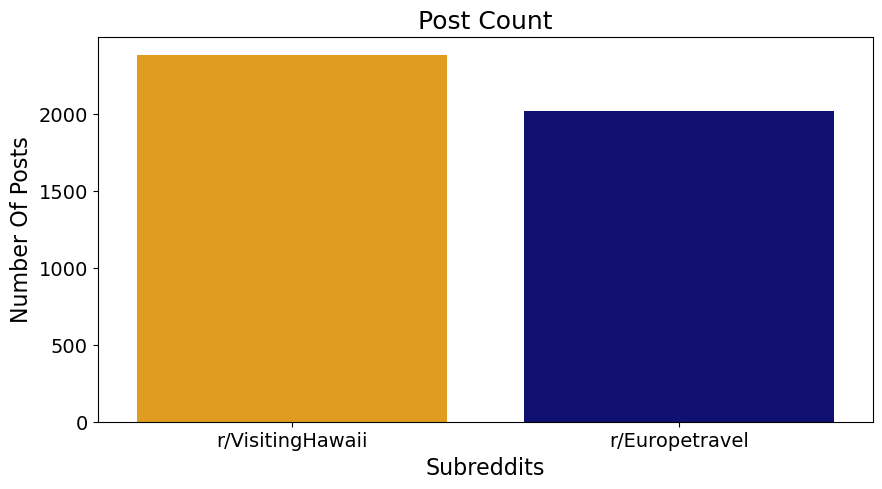

In [36]:
tick_labels = ["r/VisitingHawaii", "r/Europetravel"]

plt.figure(figsize = (10,5))

# Plotting the graph
sns.countplot(data = subreddit_df,x ="subreddit", hue = 'subreddit', palette=['orange','navy'])

# Setting graph parameters
plt.title("Post Count", size = 18)
plt.xlabel("Subreddits", size = 16)
plt.ylabel("Number Of Posts", size = 16)

# Making sure the only ticks are 0 and 1
plt.xticks(np.arange(0,2,1), 
           labels = tick_labels, 
           size   = 14)
plt.yticks(size = 14)
plt.savefig('../Presentation/Figures/Post Count.png', dpi = 200)

#### Title word count

/Users/yilan.c/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_8232/1792903651.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

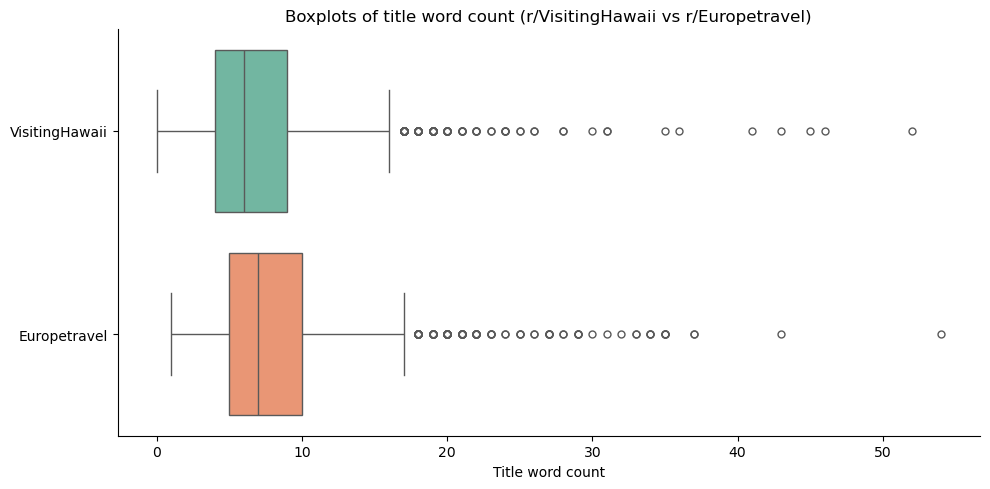

In [37]:
plt.figure(figsize=(12,8))
g = sns.catplot(x='title_words_count', y='subreddit', kind='box', hue = 'subreddit', \
                data=subreddit_df, height=5, aspect=2, palette='Set2')
plt.title('Boxplots of title word count (r/VisitingHawaii vs r/Europetravel)')
plt.xlabel('Title word count')
plt.ylabel('')

# Adjust layout to prevent the title from being cut off
plt.tight_layout()

plt.savefig('../Presentation/Figures/Boxplots of title word count.png', dpi=200)
plt.show();

#### Self Text word count

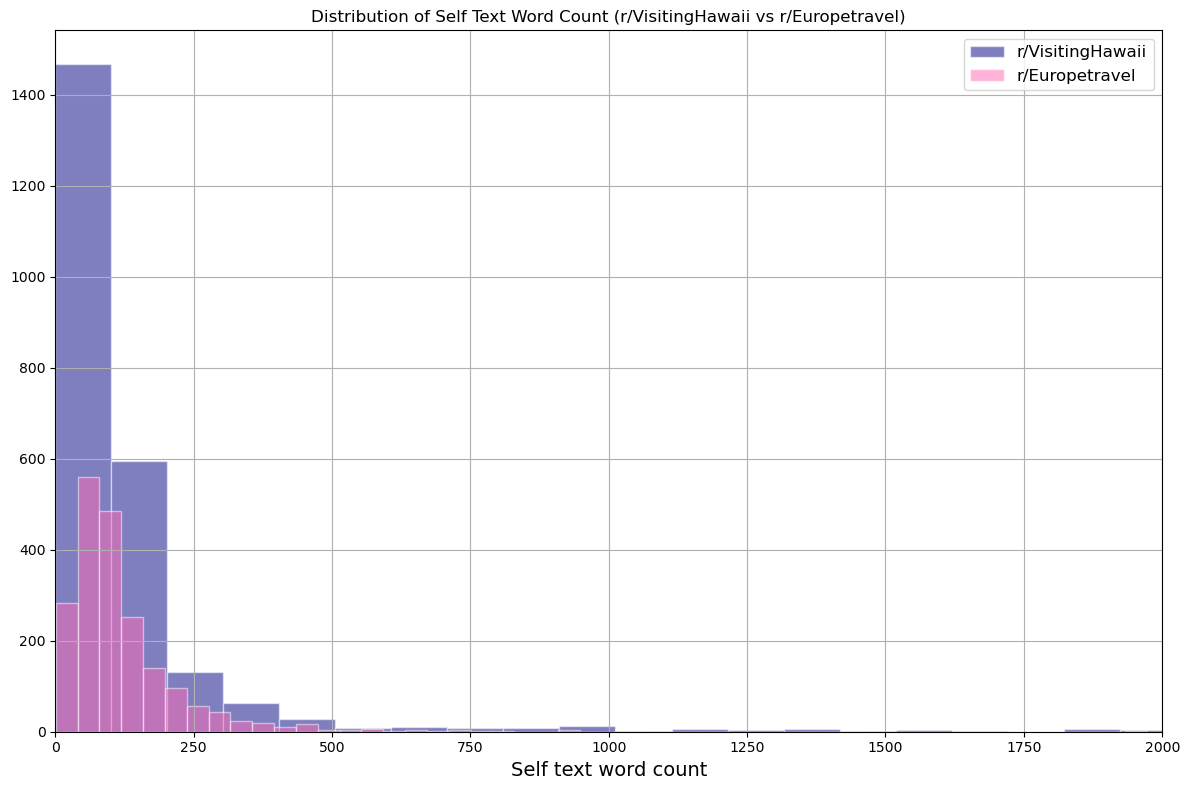

In [40]:
plt.figure(figsize=(12,8))

plt.hist(subreddit_df[subreddit_df['subreddit'] == 'VisitingHawaii']['selftext_words_count'], \
             bins=50, color='navy', edgecolor = "white",alpha=0.5, label='r/VisitingHawaii')

# Plot histogram for subreddit 'r/Europetravel'
plt.hist(subreddit_df[subreddit_df['subreddit'] == 'Europetravel']['selftext_words_count'], \
             bins=50, color='hotpink', edgecolor = "white",alpha=0.5, label='r/Europetravel')

plt.title('Distribution of Self Text Word Count (r/VisitingHawaii vs r/Europetravel)')
plt.xlabel('Self text word count', size = 14)
plt.xlim(0,2000)
plt.legend(fontsize='large')
plt.grid(True)

plt.tight_layout()

plt.savefig('../Presentation/Figures/Boxplots of self text word count.png', dpi=200)
plt.show();

### Text Normalizing

#### Tokenize - only keep English words

In [72]:
def tokenize(text):
    tokenizer = RegexpTokenizer('[a-zA-Z]{3,}')
    tokens = tokenizer.tokenize(text)
    return " ".join(tokens)

In [73]:
subreddit_df['token_selftext']= subreddit_df['cleaned_selftext'].apply(lambda x: tokenize(x.lower()))

subreddit_df['token_fulltext']= subreddit_df['full_text'].apply(lambda x: tokenize(x.lower()))

In [74]:
df['token_selftext']= df['cleaned_selftext'].apply(lambda x: tokenize(x.lower()))

df['token_fulltext']= df['full_text'].apply(lambda x: tokenize(x.lower()))

In [75]:
df_t['token_selftext']= df_t['cleaned_selftext'].apply(lambda x: tokenize(x.lower()))

df_t['token_fulltext']= df_t['full_text'].apply(lambda x: tokenize(x.lower()))

#### Lematize verbs

In [76]:
def lemmatize_review(input_text):
    text = input_text.split()
    wn = WordNetLemmatizer()
    return " ".join([wn.lemmatize(word,'v') for word in text])


In [77]:
subreddit_df['lemmatized_text'] = subreddit_df['token_fulltext'].apply(lemmatize_review)

In [78]:
subreddit_df.sample(5,random_state = 42)

,created_utc,title,self_text,subreddit,cleaned_title,cleaned_selftext,created_datetime,date,time,year,month,title_emoji_count,selftext_emoji_count,full_text,title_words_count,selftext_words_count,full_text_count,token_selftext,token_fulltext,lemmatized_text
274,1.707256e+09,Family trip to Waianae?,My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,VisitingHawaii,Family trip to Waianae?,My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,2024-02-06 21:40:15,2024-02-06,21:40:15,2024,2,0,0,Family trip to Waianae? My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,4,67,71,family and are trying plan trip ahu and step mom found something close waianae the first time wife and went didn the west side the island kind had heart set being around waikiki since its family trip and theres lot there would waianae worth,family trip waianae family and are trying plan trip ahu and step mom found something close waianae the first time wife and went didn the west side the island kind had heart set being around waikiki since its family trip and theres lot there would waianae worth,family trip waianae family and be try plan trip ahu and step mom find something close waianae the first time wife and go didn the west side the island kind have heart set be around waikiki since its family trip and theres lot there would waianae worth
3430,1.687176e+09,Thank you Paris!,"I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23.\n\nSo during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we missed the 10 PM spa...",Europetravel,Thank you Paris!,"I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23. So during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we missed the 10 PM spark...",2023-06-19 12:07:07,2023-06-19,12:07:07,2023,6,0,1,"Thank you Paris! I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23. So during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we misse...",3,233,236,went with wife for days paris and had amazing time parisians are really helpful especially when they see tourist confused the metros but what particularly touched was incident during our last night paris june during our days trip saw everything and had kept eiffel tower the last day however during the night time missed the sparkle due some confusion were cab and rushing see the sparkle luckily...,thank you paris went with wife for days paris and had amazing time parisians are really helpful especially when they see tourist confused the metros but what p

In [79]:
df['lemmatized_text'] = df['token_fulltext'].apply(lemmatize_review)

In [80]:
df_t['lemmatized_text'] = df_t['token_fulltext'].apply(lemmatize_review)

### Sentiment Analysis

In [81]:
sa = SentimentIntensityAnalyzer()

In [82]:
def get_sentiment_score(text):
    scores = sa.polarity_scores(text)
    return scores['compound']

In [83]:
subreddit_df['sentiment'] = subreddit_df['lemmatized_text'].apply(get_sentiment_score)

In [84]:
subreddit_df.sample(5,random_state=42)

,created_utc,title,self_text,subreddit,cleaned_title,cleaned_selftext,created_datetime,date,time,year,...,title_emoji_count,selftext_emoji_count,full_text,title_words_count,selftext_words_count,full_text_count,token_selftext,token_fulltext,lemmatized_text,sentiment
274,1.707256e+09,Family trip to Waianae?,My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,VisitingHawaii,Family trip to Waianae?,My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,2024-02-06 21:40:15,2024-02-06,21:40:15,2024,...,0,0,Family trip to Waianae? My family and I are trying to plan a trip to O'ahu and my step mom found something close to Waianae. The first time my wife and I went we didn't go to the west side of the island. I kind of had my heart set on being around Waikiki since its a family trip and theres a lot to do there. Would Waianae be worth it?,4,67,71,family and are trying plan trip ahu and step mom found something close waianae the first time wife and went didn the west side the island kind had heart set being around waikiki since its family trip and theres lot there would waianae worth,family trip waianae family and are trying plan trip ahu and step mom found something close waianae the first time wife and went didn the west side the island kind had heart set being around waikiki since its family trip and theres lot there would waianae worth,family trip waianae family and be try plan trip ahu and step mom find something close waianae the first time wife and go didn the west side the island kind have heart set be around waikiki since its family trip and theres lot there would waianae worth,0.6486
3430,1.687176e+09,Thank you Paris!,"I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23.\n\nSo during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we missed the 10 PM spa...",Europetravel,Thank you Paris!,"I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23. So during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we missed the 10 PM spark...",2023-06-19 12:07:07,2023-06-19,12:07:07,2023,...,0,1,"Thank you Paris! I went with my wife for 4 days in Paris and I had an amazing time. Parisians are really helpful especially when they see a tourist confused in the metros. But what particularly touched me was a incident during our last night in Paris on 17th June,23. So during our 4 days trip we saw everything and had kept Eiffel tower on the last day. However, during the night time, we misse...",3,233,236,went with wife for days paris and had amazing time parisians are really helpful especially when they see tourist confused the metros but what particularly touched was incident during our last night paris june during our days trip saw everything and had kept eiffel tower the last day however during the night time missed the sparkle due some confusion were cab and rushing see the sparkle luckily...,thank you paris went with wife for days paris and had amazing time parisians are really helpful especially when they see tourist confused th

In [85]:
subreddit_df.sort_values(by='sentiment',ascending=False).head()\
[['full_text','title','self_text','subreddit','sentiment']]

,full_text,title,self_text,subreddit,sentiment
938,"Post Trip Write-Up: Two Weeks on Big Island Hello everyone! ​ I have used this sub (and the previous sub) extensively over the last 5 months to plan my two week vacation to Big Island. We just got back, and I wanted to share my feedback on everything we did. Some things we found on here, others we found on our own. We broke out our trip with a break to visit Hilo in the middle, but I am goin...",Post Trip Write-Up: Two Weeks on Big Island,"Hello everyone!\n\n&#x200B;\n\nI have used this sub (and the previous sub) extensively over the last 5 months to plan my two week vacation to Big Island. We just got back, and I wanted to share my feedback on everything we did. Some things we found on here, others we found on our own. We broke out our trip with a break to visit Hilo in the middle, but I am going to group the things we did by r...",VisitingHawaii,1.0000
1343,"Oahu Trip report (long): October 5th – October 14th (Wedding + Honeymoon) Hello all! I wanted to write up a summary of a recent trip to Oahu. This sub was helpful when planning our trip, and I found itinerary posts and summary posts particularly helpful. My husband and I spent 10 days on Oahu – where the first few days were dedicated to getting ready for and having our wedding, and the remaini...",Oahu Trip report (long): October 5th – October 14th (Wedding + Honeymoon),"Hello all! I wanted to write up a summary of a recent trip to Oahu. This sub was helpful when planning our trip, and I found itinerary posts and summary posts particularly helpful. My husband and I spent 10 days on Oahu – where the first few days were dedicated to getting ready for and having our wedding, and the remaining time was for the honeymoon. \n\nWe stayed pretty true to our itinerary,...",VisitingHawaii,1.0000
966,Very Long Trip Report of our 2 Week Stay on Oahu and BI! Recently got back from an **awesome** 2 week stay on Oahu and the Big Island with my husband. We had never been to either. This was a delayed 10th anniversary celebration for us and a big splurge/treating ourselves kind of trip. We had previously been to Maui twice and Kauai once and loved those as well. I don’t think I’d be able to pi...,Very Long Trip Report of our 2 Week Stay on Oahu and BI!,"Recently got back from an **awesome** 2 week stay on Oahu and the Big Island with my husband. We had never been to either. This was a delayed 10th anniversary celebration for us and a big splurge/treating ourselves kind of trip. \n\nWe had previously been to Maui twice and Kauai once and loved those as well. I don’t think I’d be able to pick a favorite, we’ve really enjoyed all our trips to Ha...",VisitingHawaii,1.0000
1149,Trip Report - 2 weeks in Big Island/Kauai/HNL Aloha! Since the many that have shared their itineraries have helped us the most I thought I would return the favor and share our own. We are a backpacking French couple living in Montreal who got a discounted return flight to Honolulu. We decided we wanted an adventure/beach based trip and opted for Big Island and Kauai with the last day spent ...,Trip Report - 2 weeks in Big Island/Kauai/HNL,Aloha!\n\nSince the many that have shared their itineraries have helped us the most I thought I would return the favor and share our own.\n\nWe are a backpacking French couple living in Montreal who got a discounted return flight to Honolulu.\n\nWe decided we wanted an adventure/beach based trip and opted for Big Island and Kauai with the last day spent in Honolulu before the flight for a pool...,VisitingHawaii,0.9999
984,Big Island trip of a lifetime! Thank you to all of you in this sub for your amazing advice and answers. It made our stay on the Big Island super special and a BLAST! Disclaimer: I know this is long. Skip around and read the sections you're interested in! FAVORITE FOOD: Flourless Chocolate Cake at Canoehouse (killer) FAVORITE ALCOHOL: Volcano Winery Wines (all) FAVORITE BEACH: Beach 69 FAV...,Big Island trip of a lif

In [86]:
subreddit_df.sort_values(by='sentiment',ascending=False).tail()\
[['full_text','title','self_text','subreddit','sentiment']]

,full_text,title,self_text,subreddit,sentiment
1150,"Car rental accident. Guy at fault arrested, possible drugs. What to do next? Within an hour of getting car rental, I was t-boned by a guy that ran the red light. Cops immediately were at scene, the guy was across the street from me but I did not interact with him, he did not look stable. The police checked on me and was okay, just a bit shaken at the time. They filed a police report, also had ...","Car rental accident. Guy at fault arrested, possible drugs. What to do next?","Within an hour of getting car rental, I was t-boned by a guy that ran the red light. Cops immediately were at scene, the guy was across the street from me but I did not interact with him, he did not look stable. The police checked on me and was okay, just a bit shaken at the time. They filed a police report, also had a witness. They proceeded to handcuff the guy and search his car. His license...",VisitingHawaii,-0.9369
3734,"My flight got cancelled in advance due to bad expected weather, but the weather turned out fine… am I owed compensation? I’ll probably get roasted for this in the comments, but I believe it is a valid question. My flight was cancelled approximately 40 hours before it was due to depart because of a severe weather forecast. Other airlines flying the same route did not pull the trigger on cancell...","My flight got cancelled in advance due to bad expected weather, but the weather turned out fine… am I owed compensation?","\nI’ll probably get roasted for this in the comments, but I believe it is a valid question. My flight was cancelled approximately 40 hours before it was due to depart because of a severe weather forecast. Other airlines flying the same route did not pull the trigger on cancelling their flights. About 12 hours after the flight got cancelled, the weather forecast got significantly downgraded and...",Europetravel,-0.9381
1395,"Criminal Citation on Waikiki Hi, I was in Honolulu two weeks ago for my grandmother's funeral at Punchbowl. Towards the end of my trip I was laying on the beach with a hard seltzer in the sand. I didn't realize it was illegal and the can was in plain view. A policeman approached me and gave me a criminal citation with three separate charges for the seltzer (prohibition, failure to follow park ...",Criminal Citation on Waikiki,"Hi, I was in Honolulu two weeks ago for my grandmother's funeral at Punchbowl. Towards the end of my trip I was laying on the beach with a hard seltzer in the sand. I didn't realize it was illegal and the can was in plain view. A policeman approached me and gave me a criminal citation with three separate charges for the seltzer (prohibition, failure to follow park signs, and failure to follow ...",VisitingHawaii,-0.9571
4317,"Concerned about overstaying, risk or paranoia? Hello everyone! My situation is a bit long to explain, so read it if you have time only. Tldr: Schengen count Entered 03/02 left 17/03; entered 20/03 left 06/04. Entered 06/07. Can I leave on 21/09 without risk for overstaying? Please don't judge me for asking this, I might be a little bit overreacting or paranoic, but I just wanted to see what ...","Concerned about overstaying, risk or paranoia?","Hello everyone! My situation is a bit long to explain, so read it if you have time only.\n\nTldr: Schengen count Entered 03/02 left 17/03; entered 20/03 left 06/04. Entered 06/07. Can I leave on 21/09 without risk for overstaying?\n\nPlease don't judge me for asking this, I might be a little bit overreacting or paranoic, but I just wanted to see what people who understand this would say.\n\nS...",Europetravel,-0.9633
3926,"overstay & reentry in france hi all— I overstayed unintentionally in france. I didn’t get stamped in greece & thought I “reset” in morocco. obviously my full bad & I realized before i left. I thought I would have so many issues at the airport, but I had none. my passport got scanned twice— once before I even checked in & nothing. then again at 

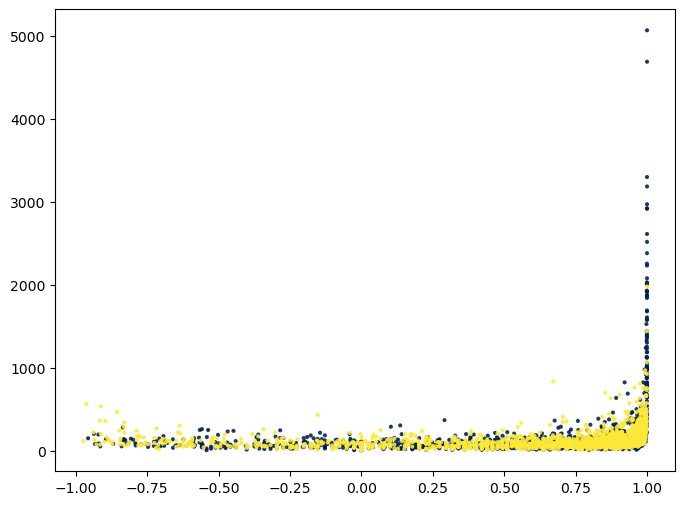

In [87]:
# Define a color map based on unique subreddit
color_map = {subreddit: idx for idx, subreddit in enumerate(subreddit_df['subreddit'].unique())}

# Map each subreddit to a color index
colors = [color_map[subreddit] for subreddit in subreddit_df['subreddit']]

plt.figure(figsize=(8, 6)) 
plt.scatter(y = subreddit_df['full_text_count'],x = subreddit_df['sentiment'], \
            cmap='cividis',c = colors, alpha=0.8, s = 4)

plt.show()

In [88]:
group_sentiment = subreddit_df.groupby('subreddit')['sentiment'].mean()

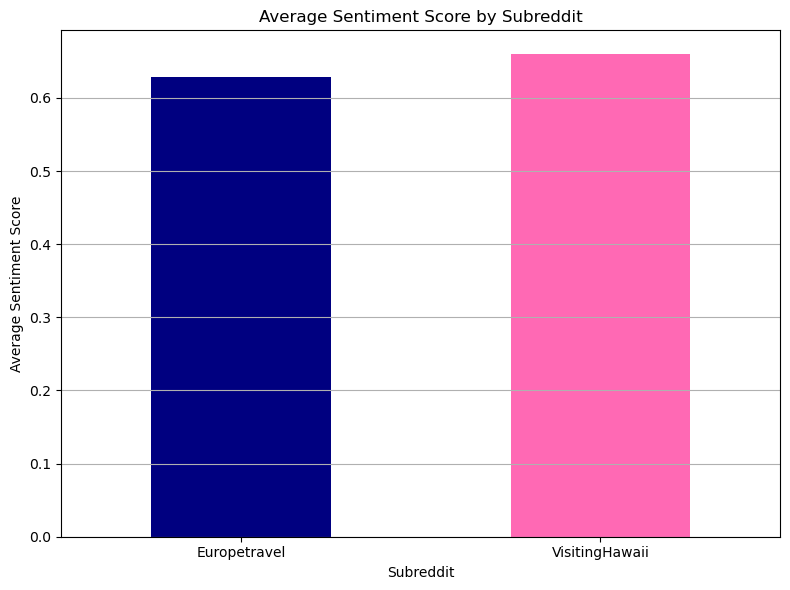

In [89]:
plt.figure(figsize=(8, 6))
group_sentiment.plot(kind='bar', color=['navy', 'hotpink'])
plt.title('Average Sentiment Score by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add grid lines on y-axis

plt.tight_layout()

plt.savefig('../Presentation/Figures/Average sentiment score by subreddit.png', dpi=200)
plt.show();

/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_7341/2856441345.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='subreddit', y='sentiment', data=subreddit_df, palette='Set2',)


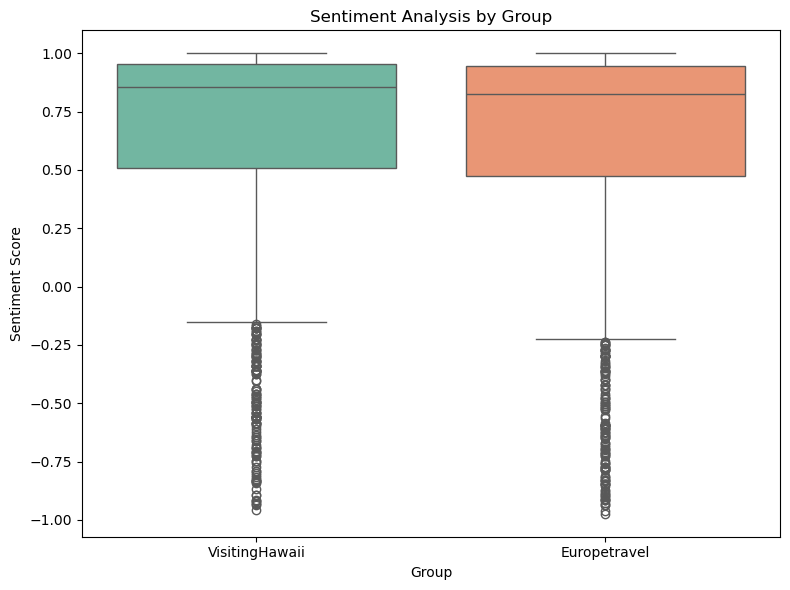

In [90]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='subreddit', y='sentiment', data=subreddit_df, palette='Set2',)
plt.title('Sentiment Analysis by Group')
plt.xlabel('Group')
plt.ylabel('Sentiment Score')

plt.tight_layout()

plt.savefig('../Presentation/Figures/Sentiment score by subreddit boxplot.png', dpi=200)
plt.show();

### Frequency used words

In [91]:
print(subreddit_df.columns)

Index(['created_utc', 'title', 'self_text', 'subreddit', 'cleaned_title',
       'cleaned_selftext', 'created_datetime', 'date', 'time', 'year', 'month',
       'title_emoji_count', 'selftext_emoji_count', 'full_text',
       'title_words_count', 'selftext_words_count', 'full_text_count',
       'token_selftext', 'token_fulltext', 'lemmatized_text', 'sentiment'],
      dtype='object')


In [92]:
X = df['lemmatized_text']

/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_7341/3900036529.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hawaii_top_words.index, y=hawaii_top_words.values, palette='colorblind')


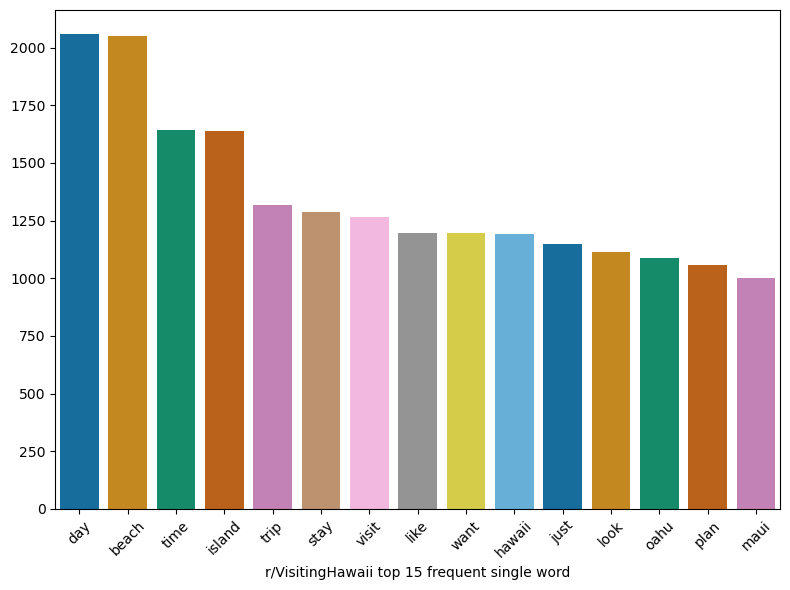

In [93]:
cvec = CountVectorizer(stop_words='english')

cvec.fit(X)
X_cv = cvec.transform(X)

X_df = pd.DataFrame(X_cv.todense(),columns=cvec.get_feature_names_out())

hawaii_top_words = X_df.sum().sort_values(ascending = False).head(15)

colors = plt.cm.viridis(np.linspace(0,1,len(hawaii_top_words)))

plt.figure(figsize=(8, 6))
sns.barplot(x=hawaii_top_words.index, y=hawaii_top_words.values, palette='colorblind')
plt.xlabel('r/VisitingHawaii top 15 frequent single word')
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('../Presentation/Figures/Frequent word bar plot.png', dpi=200)
plt.show();

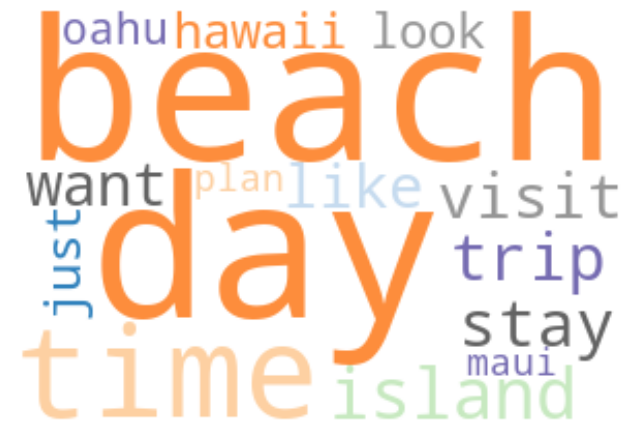

In [94]:
wordcloud = WordCloud(width=300, height=200, background_color='white',colormap='tab20c').generate_from_frequencies(hawaii_top_words)

# Display the generated image:
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.savefig('../Presentation/Figures/Most frequent single word cloud Hawaii.png')
plt.show()



/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_7341/1049152876.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hawaii_top_biwords.index, y=hawaii_top_biwords.values, palette='colorblind')


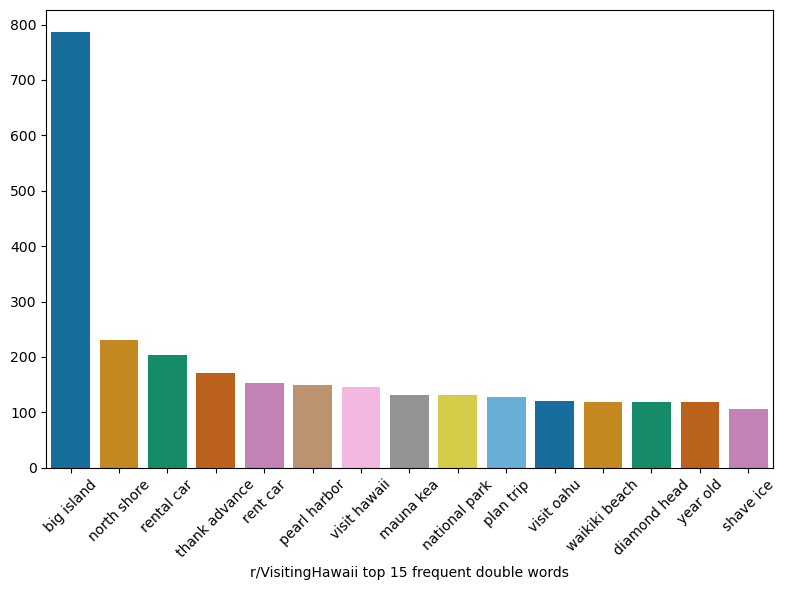

In [95]:
cvec_bi = CountVectorizer(ngram_range=(2, 3),stop_words='english')

cvec_bi.fit(X)
X_cv_bi = cvec_bi.transform(X)

X_df_bi = pd.DataFrame(X_cv_bi.todense(),columns=cvec_bi.get_feature_names_out())

hawaii_top_biwords = X_df_bi.sum().sort_values(ascending = False).head(15)

colors = plt.cm.viridis(np.linspace(0,1,len(hawaii_top_biwords)))

plt.figure(figsize=(8, 6))
sns.barplot(x=hawaii_top_biwords.index, y=hawaii_top_biwords.values, palette='colorblind')
plt.xlabel('r/VisitingHawaii top 15 frequent double words')
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('../Presentation/Figures/Frequent bigram bar plot Hawaii.png', dpi=200)
plt.show();

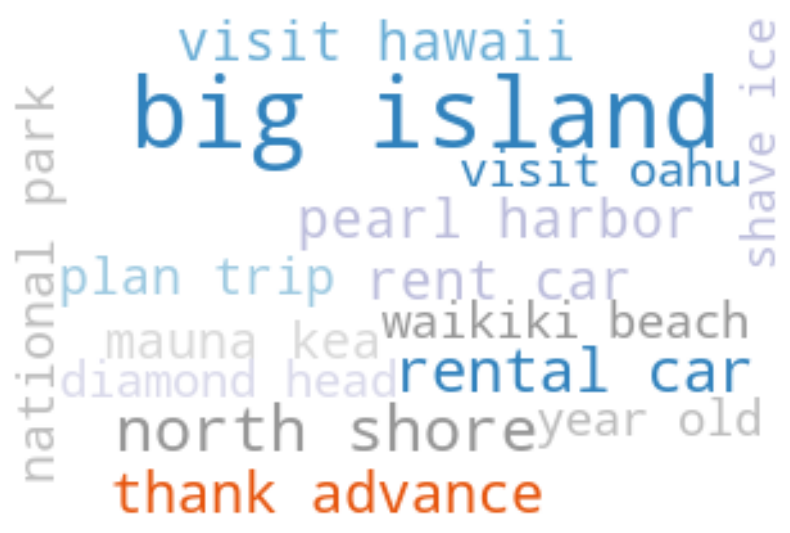

In [98]:
wordcloud = WordCloud(width=300, height=200, background_color='white',colormap='tab20c').generate_from_frequencies(hawaii_top_biwords)

# Display the generated image:
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()

plt.savefig('../Presentation/Figures/Most frequent bigram word cloud Hawaii.png')
plt.show()


In [99]:
X_t = df_t['lemmatized_text']

/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_7341/754964216.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=europe_top_words.index, y=europe_top_words.values, palette='colorblind')


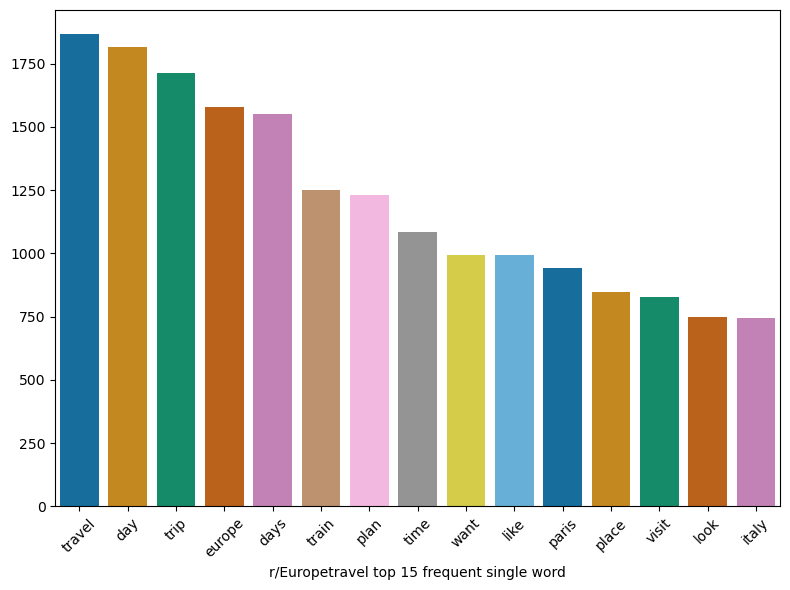

In [100]:
cvec = CountVectorizer(stop_words='english')

cvec.fit(X_t)
X_cv = cvec.transform(X_t)

X_df = pd.DataFrame(X_cv.todense(),columns=cvec.get_feature_names_out())

europe_top_words = X_df.sum().sort_values(ascending = False).head(15)

colors = plt.cm.viridis(np.linspace(0,1,len(europe_top_words)))

plt.figure(figsize=(8, 6))
sns.barplot(x=europe_top_words.index, y=europe_top_words.values, palette='colorblind')
plt.xlabel('r/Europetravel top 15 frequent single word')
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('../Presentation/Figures/Most frequent single word cloud Europe.png')
plt.show()

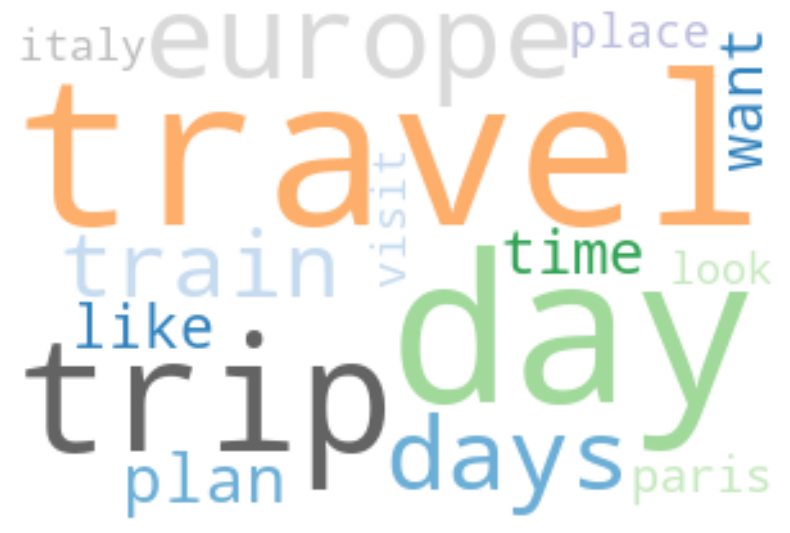

In [101]:
wordcloud = WordCloud(width=300, height=200, background_color='white',colormap='tab20c').generate_from_frequencies(europe_top_words)

# Display the generated image:
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

plt.savefig('../Presentation/Figures/Most frequent single word cloud Europe.png')
plt.show()


/var/folders/4g/t9m4gw7n7dx1x3j6srwz6zqm0000gn/T/ipykernel_7341/3624892823.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=europe_top_biwords.index, y=europe_top_biwords.values, palette='colorblind')


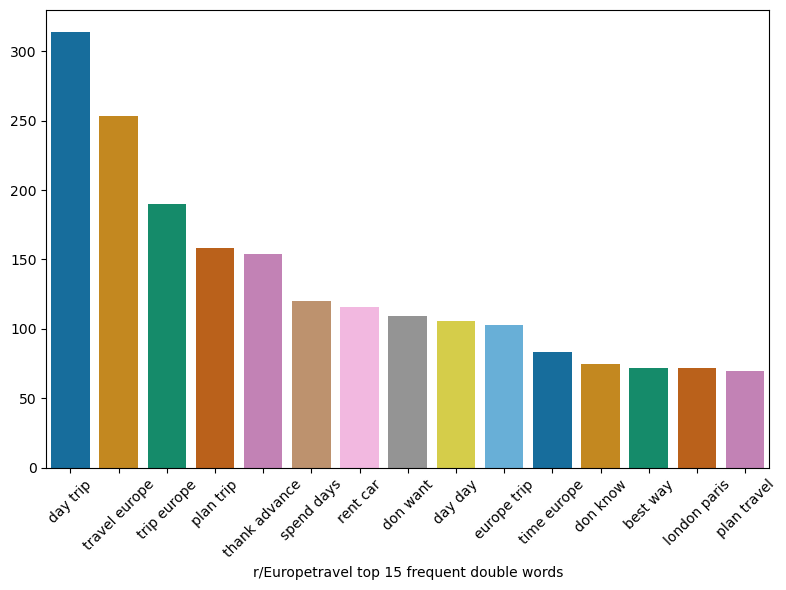

In [102]:
cvec_bi = CountVectorizer(ngram_range=(2, 3),stop_words='english')

cvec_bi.fit(X_t)
X_cv_bi = cvec_bi.transform(X_t)

X_df_bi = pd.DataFrame(X_cv_bi.todense(),columns=cvec_bi.get_feature_names_out())

europe_top_biwords = X_df_bi.sum().sort_values(ascending = False).head(15)

colors = plt.cm.viridis(np.linspace(0,1,len(europe_top_biwords)))

plt.figure(figsize=(8, 6))
sns.barplot(x=europe_top_biwords.index, y=europe_top_biwords.values, palette='colorblind')
plt.xlabel('r/Europetravel top 15 frequent double words')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../Presentation/Figures/Most frequent bigram word cloud Europe.png')
plt.show();

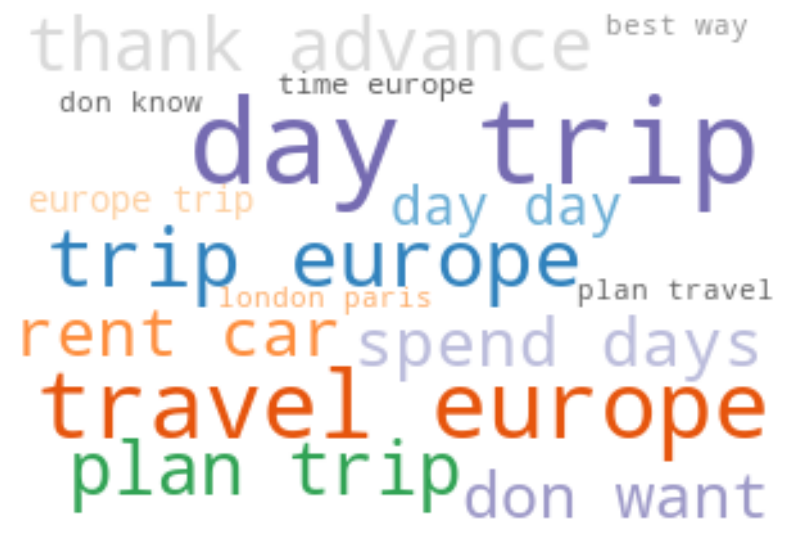

In [103]:
wordcloud = WordCloud(width=300, height=200, background_color='white',colormap='tab20c').\
    generate_from_frequencies(europe_top_biwords)

# Display the generated image:
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()

plt.savefig('../Presentation/Figures/Most frequent bigram word cloud Europe.png')
plt.show()


## Step 5. Export Clean Data

In [104]:
df.columns

Index(['created_utc', 'title', 'self_text', 'subreddit', 'cleaned_title',
       'cleaned_selftext', 'created_datetime', 'date', 'time', 'year', 'month',
       'title_emoji_count', 'selftext_emoji_count', 'full_text',
       'title_words_count', 'selftext_words_count', 'full_text_count',
       'token_selftext', 'token_fulltext', 'lemmatized_text'],
      dtype='object')

Only keeps columns that use for modeling and evaluation 

In [105]:
df = df[['subreddit','lemmatized_text']]

In [106]:
df_t = df_t[['subreddit','lemmatized_text']]

In [107]:
df_t.to_csv('../Data/Cleaned Data/reddit_posts_Europetravel_cleaned.csv',index=False)

In [108]:
df.to_csv('../Data/Cleaned Data/reddit_posts_VisitingHawaii_cleaned.csv',index=False)

### Combine 2 subreddits together

In [109]:
subreddit_df = pd.concat([df, df_t], axis=0, ignore_index=True)
subreddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        4400 non-null   object
 1   lemmatized_text  4400 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [110]:
subreddit_df.to_csv('../Data/Cleaned Data/Subreddit_travel_clean.csv',index=False)

In [111]:
subreddit_df.subreddit.unique()

array(['VisitingHawaii', 'Europetravel'], dtype=object)

In [112]:
subreddit_df.shape

(4400, 2)